### Importing Required Libraries
##### This cell imports all the necessary libraries required for image processing, handling data, and visualizing results. Libraries include `numpy`, `pandas`, `skimage` for image processing, and `matplotlib` for plotting.


In [5]:
import warnings
import numpy as np
import pandas as pd
from skimage import io, measure
from PIL import Image
import os
import math
import matplotlib.pyplot as plt
from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

### Function to Convert a 2D Image with 3 Classes to a Binary Image
##### This function reads a grayscale image and converts it into a binary image based on the class mapping provided. The image is converted into a NumPy array, and each pixel is mapped to its binary class.


In [6]:
def convert_to_binary(image_path, class_mapping):
    """
    Convert a 2D image with 3 classes to binary.
 
    :param image_path: Path to the input image
    :param class_mapping: Dictionary mapping original classes to binary classes
    :return: Binary image as a NumPy array
    """
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    img_array = np.array(image)
 
    # Apply the class mapping
    binary_array = np.vectorize(lambda x: class_mapping.get(x, 0))(img_array)
    return binary_array
 

### Function to Compute Morphometry Features for Each Object in a Labeled Image
##### This function calculates several morphometry features, such as area, eccentricity, extent, solidity, etc., for each labeled object in an image. It uses `skimage.measure.regionprops` to get the properties and stores them in a DataFrame for easy access.


In [7]:
def compute_morphometry_features(im_label, rprops=None):
    """
    Calculate morphometry features for each object in a labeled image.
    """
    # Ensure the image is labeled
    if im_label.max() <= 1 or (im_label.max() == 255 and im_label.min() == 0):
        im_label = measure.label(im_label)
   
    # Compute object properties if not provided
    if rprops is None:
        rprops = measure.regionprops(im_label)
   
    is_3d = im_label.ndim == 3
   
    # Define the feature list as tuples of (feature name, attribute or function)
    feature_list = [
        ('Size.Area', 'area'),
        ('Shape.Eccentricity', 'eccentricity'),
        ('Shape.Extent', 'extent'),
        ('Shape.Solidity', lambda rp: rp.area / rp.convex_area if rp.convex_area > 0 else np.nan),
    ]
   
    # Add 2D-specific features
    if not is_3d:
        feature_list.extend([
            ('Size.MajorAxisLength', 'major_axis_length'),
            ('Size.MinorAxisLength', 'minor_axis_length'),
            ('Size.Perimeter', lambda rp: measure.perimeter(rp.image)),
            (
                'Shape.Circularity',
                lambda rp: 4 * np.pi * rp.area / (measure.perimeter(rp.image)**2) if measure.perimeter(rp.image) > 0 else np.nan,
            ),
        ])
        
    data = []
    for prop in rprops:
        row = []
        for name, attr in feature_list:
            if callable(attr):
                try:
                    value = attr(prop)
                except Exception:
                    value = np.nan
            else:
                try:
                    value = getattr(prop, attr, np.nan)
                except Exception:
                    value = np.nan
            # Check if the feature is Area or ConvexHullArea and ensure it is a float
            if name in ('Size.Area', 'Size.ConvexHullArea'):
                value = float(value)  # Cast to float here
            row.append(value)
        data.append(row)
   
    fdata = pd.DataFrame(data, columns=[name for name, _ in feature_list])
    return fdata

### Function to Calculate the Fractal Dimension of an Object (Boundary Complexity)
##### This function calculates the fractal dimension of an object in a 2D binary image. The fractal dimension quantifies the complexity of the boundary of the object. The function uses a box-counting method to estimate the fractal dimension.


In [8]:
def _fractal_dimension(Z):
    """
    Calculate the fractal dimension of an object (boundary complexity).
    """
    # Only for 2d binary image
    assert len(Z.shape) == 2
    Z = Z > 0
   
    def boxcount(arr, k):
        S = np.add.reduceat(
            np.add.reduceat(arr, np.arange(0, arr.shape[0], k), axis=0),
            np.arange(0, arr.shape[1], k),
            axis=1)
        return len(np.where((S > 0) & (S < k * k))[0])
   
    # Minimal dimension of image
    p = min(Z.shape)
    # Greatest power of 2 less than or equal to p
    n = 2 ** np.floor(np.log(p) / np.log(2))
    # Extract the exponent
    n = int(np.log(n) / np.log(2))
    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2 ** np.arange(n, 1, -1)
    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))
   
    # Fit the successive log(sizes) with log (counts)
    coeffs = [0]
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', np.RankWarning)
        if len(counts):
            try:
                coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
            except TypeError:
                pass
    return -coeffs[0]

### Visualization of Labeled Objects in an Image
##### This cell creates a synthetic image with multiple ellipses, labels the image, and visualizes the labeled objects. The centroids, orientations, and bounding boxes of each region are plotted on the image using `matplotlib`.


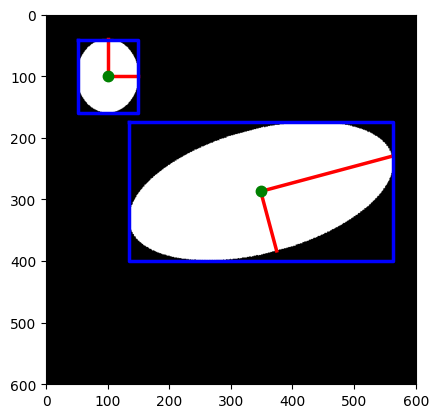

In [9]:
# Visualization code
image = np.zeros((600, 600))
rr, cc = ellipse(300, 350, 100, 220)
image[rr, cc] = 1
 
image = rotate(image, angle=15, order=0)
 
rr, cc = ellipse(100, 100, 60, 50)
image[rr, cc] = 1
 
label_img = label(image)
regions = regionprops(label_img)
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)
 
for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length
 
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)
 
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)
 
ax.axis((0, 600, 600, 0))
plt.show()

### Convert Region Properties into a DataFrame
##### This cell extracts the centroids, orientations, and axis lengths of each labeled object in the image and stores them in a pandas DataFrame for further analysis.


In [10]:
props = regionprops_table(
    label_img,
    properties=('centroid', 'orientation', 'axis_major_length', 'axis_minor_length'),
)
df_visualization = pd.DataFrame(props)
print(df_visualization)
 

   centroid-0  centroid-1  orientation  axis_major_length  axis_minor_length
0  100.000000  100.000000     0.000000         119.807049          99.823995
1  286.914167  348.412995    -1.308966         440.015503         199.918850


### Defining Class Mapping for Binary Conversion
##### Here, we define a dictionary to map the original classes of the image to binary classes. For example, pixels of class 0 and 1 are mapped to 0 (background), while class 2 is mapped to 1 (object).



In [11]:
# Define the mapping from original classes to binary classes
class_mapping = {
    0: 0,
    1: 0,
    2: 1
}

### Processing a Directory of Images and Computing Morphometry Features
##### This function processes all images in a given directory, converts them to binary using the class mapping, and then computes morphometry features for each object in the images. The features are combined into a single DataFrame.


In [12]:
def process_directory(directory_path, class_mapping):
    """
    Process all images in the given directory, convert them to binary, and compute morphometry features.
 
    :param directory_path: Path to the directory containing images
    :param class_mapping: Dictionary mapping original classes to binary classes
    :return: DataFrame with morphometry features of all images
    """
    all_features = []
   
    for filename in os.listdir(directory_path):
        if filename.endswith(".png"):  # You can add more extensions if needed
            mask_path = os.path.join(directory_path, filename)
            binary_image = convert_to_binary(mask_path, class_mapping)
            features = compute_morphometry_features(binary_image)
            all_features.append(features)
 
    # Combine all features into a single DataFrame
    result = pd.concat(all_features, ignore_index=True)
    return result
 

 
 

### Running the Image Processing on a Directory and Saving Results
##### This cell sets the directory path containing the images, processes the images to compute morphometry features, and saves the results to a CSV file for further use.


In [13]:
# Set input directory
directory_path = '/home/siri/masks'
 
# Process the directory and get the features
result = process_directory(directory_path, class_mapping)
 
# Print the results
print(result)
 
# Optionally, save the results to a CSV file
result.to_csv('morphometry_features.csv', index=False)

       Size.Area  Shape.Eccentricity  Shape.Extent  Shape.Solidity  \
0       173586.0            0.921814      0.394514        0.492179   
1      1575536.0            0.889781      0.226039        0.232343   
2          565.0            0.949901      0.387517        0.625000   
3           78.0            0.997071      0.557143        0.780000   
4        17812.0            0.558972      0.235161        0.378955   
...          ...                 ...           ...             ...   
10049        1.0            0.000000      1.000000        1.000000   
10050        1.0            0.000000      1.000000        1.000000   
10051        2.0            1.000000      1.000000        1.000000   
10052        7.0            0.991381      0.233333        0.700000   
10053        1.0            0.000000      1.000000        1.000000   

       Size.MajorAxisLength  Size.MinorAxisLength  Size.Perimeter  \
0               1098.321834            425.744375     9609.979649   
1               4072.